**Brian Blaylock**  
**March 12, 2019**

# HRRR-GLM Lightning Statistics
## SINGLE DAY

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.path import Path

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = [15,15]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.15
mpl.rcParams['figure.subplot.hspace'] = 0.15
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

SAVEDIR = '/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR_GOES/GLM_hit_rate/'
if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, get_hrrr_variable
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST

# Domain Areas
Area of each domain in square kilometers

In [2]:
Hlat, Hlon = get_hrrr_latlon(DICT=False)

PATH_points = {
    'HRRR':
        {'lon': np.concatenate([Hlon[0], Hlon[:,-1], Hlon[-1][::-1], Hlon[:,0][::-1]]),
         'lat': np.concatenate([Hlat[0], Hlat[:,-1], Hlat[-1][::-1], Hlat[:,0][::-1]])},
    'West':{
        'lon':[-120, -104, -104, -120, -120],
        'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
    'Central':{
        'lon':[-104, -88, -88, -104, -104],
        'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
    'East':{
        'lon':[-88, -72, -72, -88, -88],
        'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
    'Utah':{
        'lon':[-114.041664, -111.047526, -111.045645,  -109.051460, -109.048632, -114.051534, -114.041664],
        'lat':[41.993580, 42.002846, 40.998538, 40.998403, 36.998310, 37.000574, 41.993580]}
}

## Combine lat/lon as vertice pair as a tuple. i.e. (lon, lat).
PATH_verts = {}
for i in PATH_points.keys():
    PATH_verts[i] = np.array([(PATH_points[i]['lon'][j], PATH_points[i]['lat'][j]) for j in range(len(PATH_points[i]['lon']))])

## Generate Path objects from the vertices.
PATHS = {}
for i in PATH_verts.keys():
    PATHS[i] = Path(PATH_verts[i])

area_sqkm = {'HRRR':16811840.28,
             'West':4034896.81,
             'Central':4034896.81,
             'East':4034896.81,
             'Utah':219973.26}

# Single Datetime: Hit Rate/False Alarm Rate

Files are organized by month and hour. Each file contains GLM/HRRR statistics for all days for the file's month for a specific hour. 

In [3]:
def get_GLM_HRRR_stats_day(DATE, DOMAIN, verbose=True):
    DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/HRRR_GLM_hit_rate_data/'
    FILE = 'GLM_in_HRRR_%s_2018_m%02d_h%02d.csv' % (DOMAIN, DATE.month, DATE.hour)

    data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
    # NOTE: Set encoding to 'UTF-8' so the date doesn't return as bytes

    # Get the data from the line that cooresponds to the date requested
    line = data[DATE.day-1]

    # Double check that the line we got is the date requested
    if datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S') != DATE:
        print('WARNING: Date of this line does not match the requested DATE')
        print('Grabbed date ', line[0])
    
    if verbose:
        #number of flashes
        num_flashes = int(line[1])
        print('Got %s flashes in %s domain (%s of %s files).' % (num_flashes, DOMAIN, line[2], line[3]))
    
    return line

In [4]:
#data.dtype.names

In [5]:
#DATE = datetime(2018, 5, 14, 22) # Mallard Fire
#DATE = datetime(2018, 7, 5, 23) # Lake Christine
DATE = datetime(2018, 7, 17, 6) # July Storm
#DATE = datetime(2018, 7, 27, 0) # Missing GLM data

Domain: HRRR
Got 17869 flashes in HRRR domain (180 of 180 files).
Domain: West
Got 2540 flashes in West domain (180 of 180 files).
Domain: Central
Got 10847 flashes in Central domain (180 of 180 files).
Domain: East
Got 4058 flashes in East domain (180 of 180 files).
Domain: Utah
Got 1228 flashes in Utah domain (180 of 180 files).

        Hit Rate - Percentage of GLM flashes that happened inside a HRRR forecasted lightning area.
False Alarm Rate - Percentage of HRRR forecasted lighnting area that had a GLM flash.



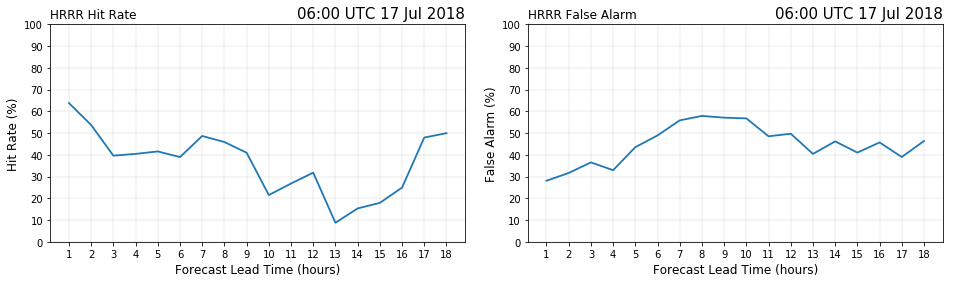

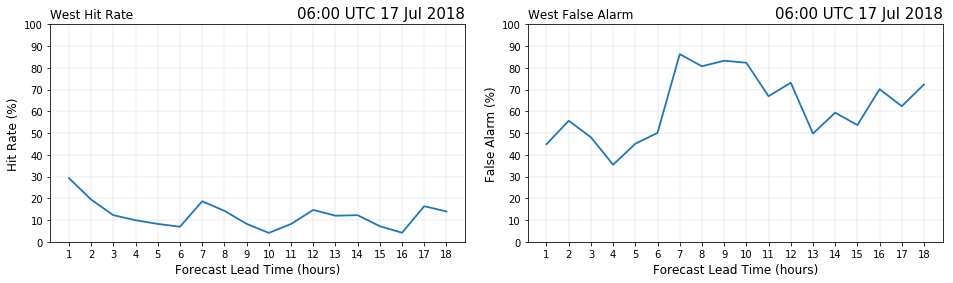

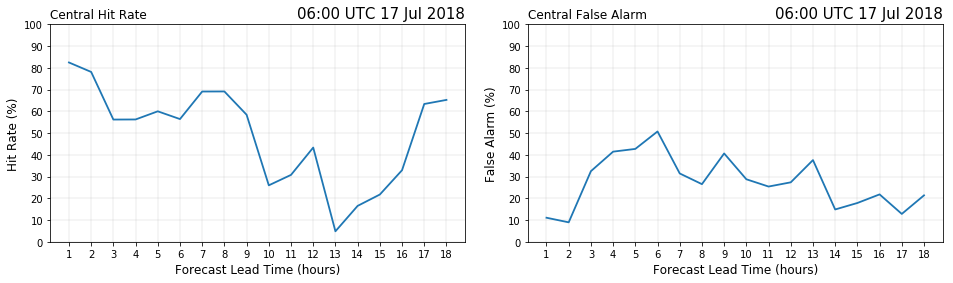

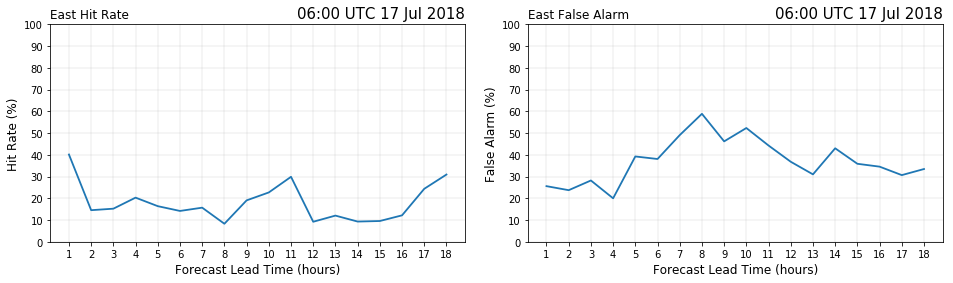

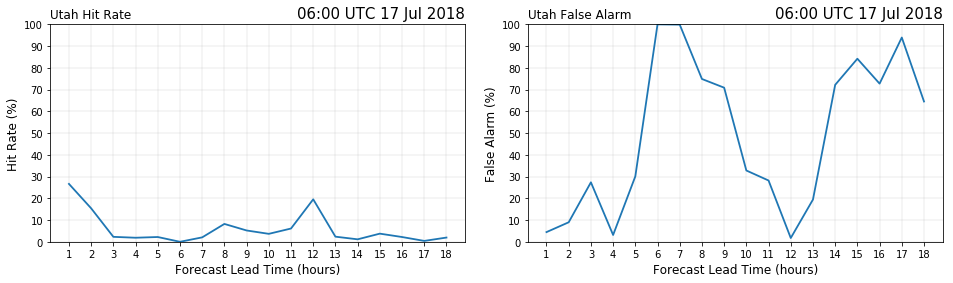

In [13]:
titles = ('Hit_Rate', 'False_Alarm')

for D in PATHS.keys():
    print('Domain:', D)
    line = get_GLM_HRRR_stats_day(DATE, D)

    fig, axes = plt.subplots(1, 2, figsize=(16,4))

    for i, (ax, name) in enumerate(zip(axes, titles)):
        plt.sca(ax) 

        fxx_values = np.array([line['F%02d_%s' % (i, name)] for i in range(19)])*100

        plt.plot(range(1,19), fxx_values[1:])
        plt.title('%s %s' % (D, name.replace('_', ' ')), loc='left', fontsize=12)
        plt.title('%s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right')
        plt.xlabel('Forecast Lead Time (hours)')
        plt.ylabel('%s (%%)' % name.replace('_', ' '))
        plt.ylim([0,100])
        plt.yticks(range(0,101,10))
        plt.xticks(range(1,19))
        plt.grid()

print()
print('        Hit Rate - Percentage of GLM flashes that happened inside a HRRR forecasted lightning area.')
print('False Alarm Rate - Percentage of HRRR forecasted lighnting area that had a GLM flash.\n')

# Flash Density

Domain: HRRR
Got 17869 flashes in HRRR domain (180 of 180 files).
Domain: West
Got 2540 flashes in West domain (180 of 180 files).
Domain: Central
Got 10847 flashes in Central domain (180 of 180 files).
Domain: East
Got 4058 flashes in East domain (180 of 180 files).
Domain: Utah
Got 1228 flashes in Utah domain (180 of 180 files).

 Hit Flash Density - Hit flashes per LTNG forecasted area.
Miss Flash Density - Miss flashes per (Domain area - LTNG forecasted area).



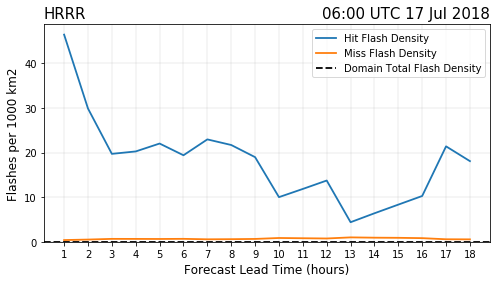

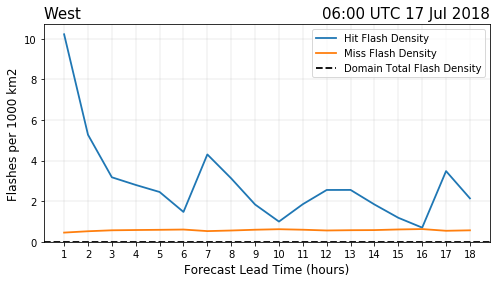

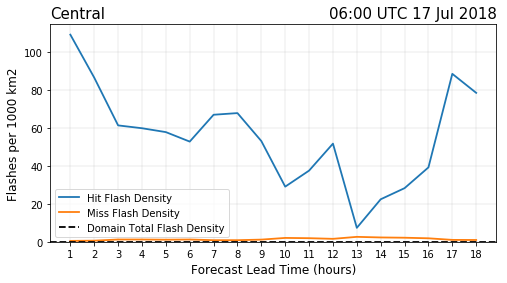

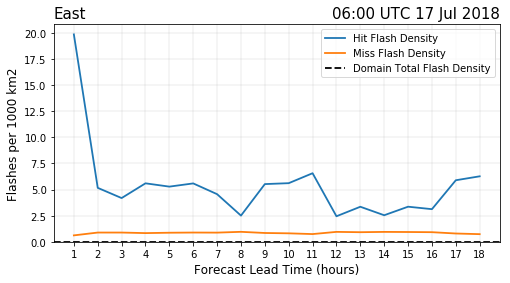

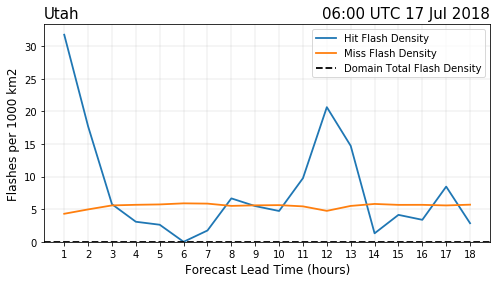

In [42]:
for D in PATHS.keys():
    print('Domain:', D)
    line = get_GLM_HRRR_stats_day(DATE, D)

    fig, ax = plt.subplots(1, 1, figsize=(8,4))

    flashes = int(line[1])
    DOM_area = area_sqkm[D]
    hit_rate = np.array([line['F%02d_Hit_Rate' % (i)] for i in range(19)])[1:]
    LTNG_area = np.array([line['F%02d_Total_Area_km2' % (i)] for i in range(19)])[1:]

    hit_density = flashes*hit_rate/LTNG_area*1000
    miss_density = flashes*(1-hit_rate)/(DOM_area-LTNG_area)*1000
    
    ## Alternate definition of Hit/Miss Density
    #hit_density = flashes*hit_rate/DOM_area*1000
    #miss_density = flashes*(1-hit_rate)/DOM_area*1000
    
    plt.plot(range(1,19), hit_density, label='Hit Flash Density')
    plt.plot(range(1,19), miss_density, label='Miss Flash Density')
    plt.axhline(flashes/DOM_area, linestyle='--', color='k', label='Domain Total Flash Density')

    plt.title('%s' % D, loc='left')
    plt.title('%s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right')
    plt.xlabel('Forecast Lead Time (hours)')
    plt.ylabel('Flashes per 1000 km2')
    plt.ylim(ymin=0)
    #plt.ylim([0,.12])
    plt.xticks(range(1,19))

    plt.grid()
    plt.legend()

print()
print(' Hit Flash Density - Hit flashes per LTNG forecasted area.')
print('Miss Flash Density - Miss flashes per (Domain area - LTNG forecasted area).\n')

In [31]:
ln1

# Percent of Area with LTNG Forecasted Lightning

Domain: HRRR
Domain: West
Domain: Central
Domain: East
Domain: Utah


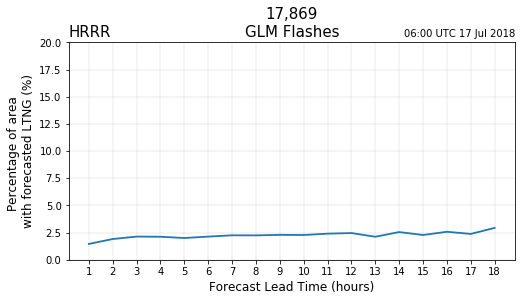

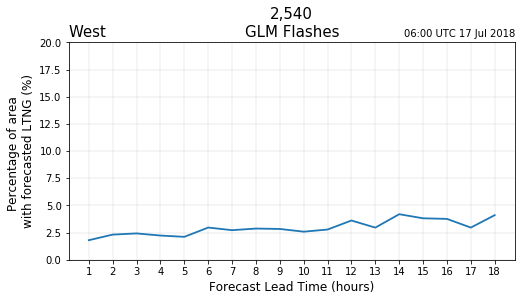

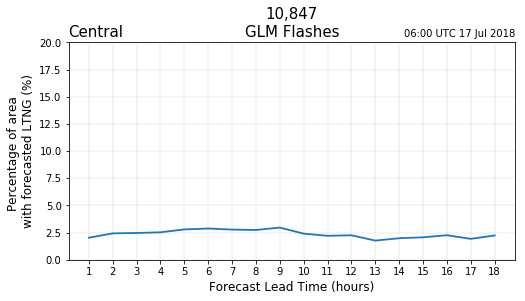

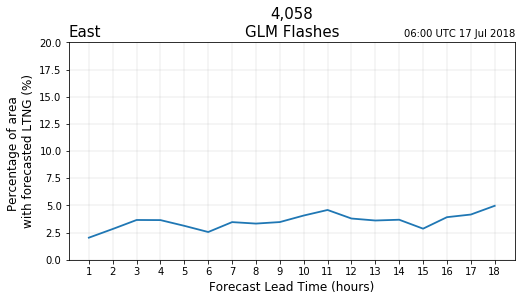

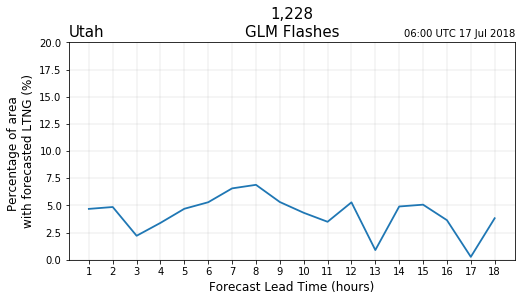

In [8]:
for D in PATHS.keys():
    print('Domain:', D)
    line = get_GLM_HRRR_stats_day(DATE, D, verbose=False)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(8,4))

    flashes = line[1]
    fxx_area = np.array([line['F%02d_Total_Area_km2' % (i)] for i in range(19)])*100

    plt.plot(range(1,19), fxx_area[1:]/area_sqkm[D])

    plt.title('{:,}\nGLM Flashes'.format(flashes))
    plt.title('%s' % D, loc='left')
    plt.title('%s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right', fontsize=10)
    plt.xlabel('Forecast Lead Time (hours)')
    plt.ylabel('Percentage of area \nwith forecasted LTNG (%)')
    plt.ylim([0,20])
    #plt.yticks(range(0,101,10))
    plt.xticks(range(1,19))
    plt.grid()

# HRRR and GLM Map

In [9]:
m = draw_HRRR_map()

In [236]:
#DATE = datetime(2018, 5, 14, 22) # Mallard Fire
#DATE = datetime(2018, 7, 5, 23) # Lake Christine
#DATE = datetime(2018, 7, 17, 6) # July Storm
DATE = datetime(2019, 3, 14, 10) # Midlatitude Cyclone

In [237]:
G = accumulate_GLM_FAST(get_GLM_file_nearesttime(DATE-timedelta(minutes=30), window=30, verbose=False))

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


|   F01   | Hit Rate | False Alarm  | Flash Density | LTNG Fraction | HitFlashDensity | MissFlashDensity |
| Domain  | Percent  |   Percent    | Flash/1e3km2  |    Percent    |  Flash/1e3km2   |   Flash/1e3km2   |
|---------|----------|--------------|---------------|---------------|-----------------|------------------|
|  HRRR   |   86.33% |      52.95%  |         0.245 |         0.79% |           26.73 |           0.0337 |
|  West   |     nan% |      100.0%  |           0.0 |    0.0004413% |             nan |              nan |
| Central |   87.05% |      32.65%  |          1.01 |        2.214% |           39.73 |           0.1338 |
|  East   |    2.86% |      94.36%  |       0.00867 |        1.088% |          0.0228 |         0.008519 |
|  Utah   |     nan% |        0.0%  |           0.0 |          0.0% |             nan |              nan |

|   F06   | Hit Rate | False Alarm  | Flash Density | LTNG Fraction | HitFlashDensity | MissFlashDensity |
| Domain  | Percent  |   Percent    

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


|   F18   | Hit Rate | False Alarm  | Flash Density | LTNG Fraction | HitFlashDensity | MissFlashDensity |
| Domain  | Percent  |   Percent    | Flash/1e3km2  |    Percent    |  Flash/1e3km2   |   Flash/1e3km2   |
|---------|----------|--------------|---------------|---------------|-----------------|------------------|
|  HRRR   |     0.0% |        0.0%  |         0.245 |          0.0% |             nan |           0.2446 |
|  West   |     nan% |        0.0%  |           0.0 |          0.0% |             nan |              nan |
| Central |     0.0% |        0.0%  |          1.01 |          0.0% |             nan |             1.01 |
|  East   |     0.0% |        0.0%  |       0.00867 |          0.0% |             nan |         0.008674 |
|  Utah   |     nan% |        0.0%  |           0.0 |          0.0% |             nan |              nan |



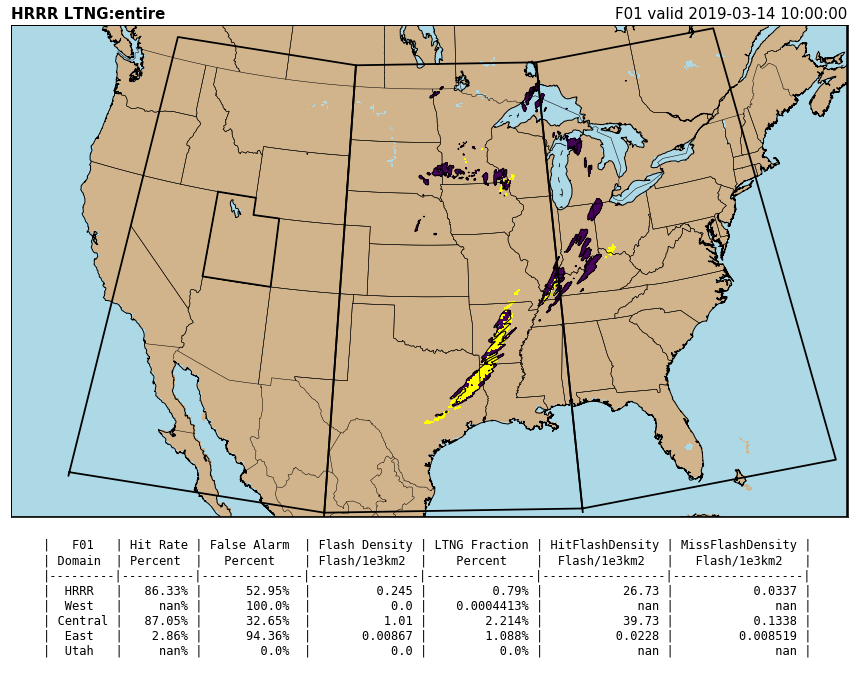

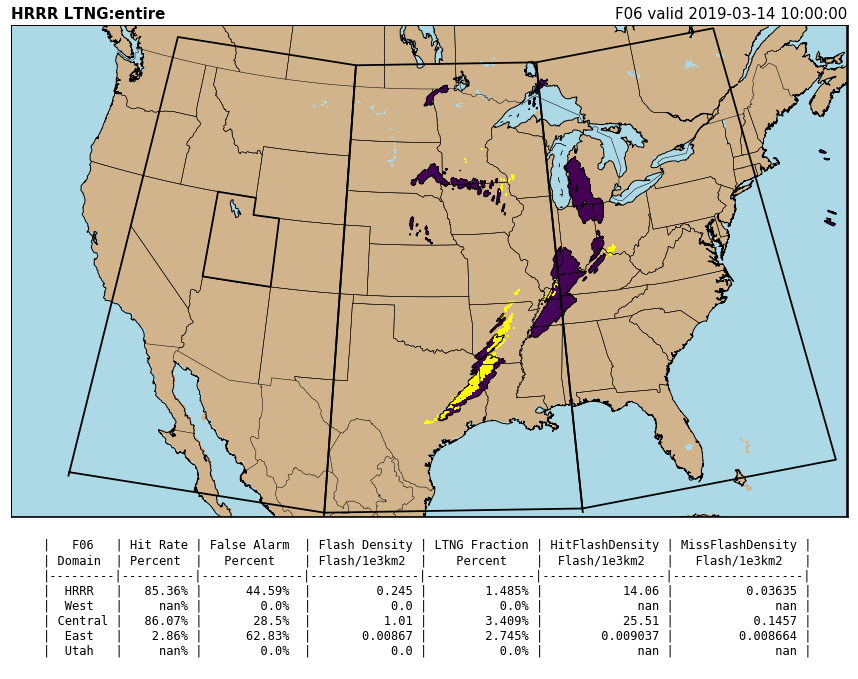

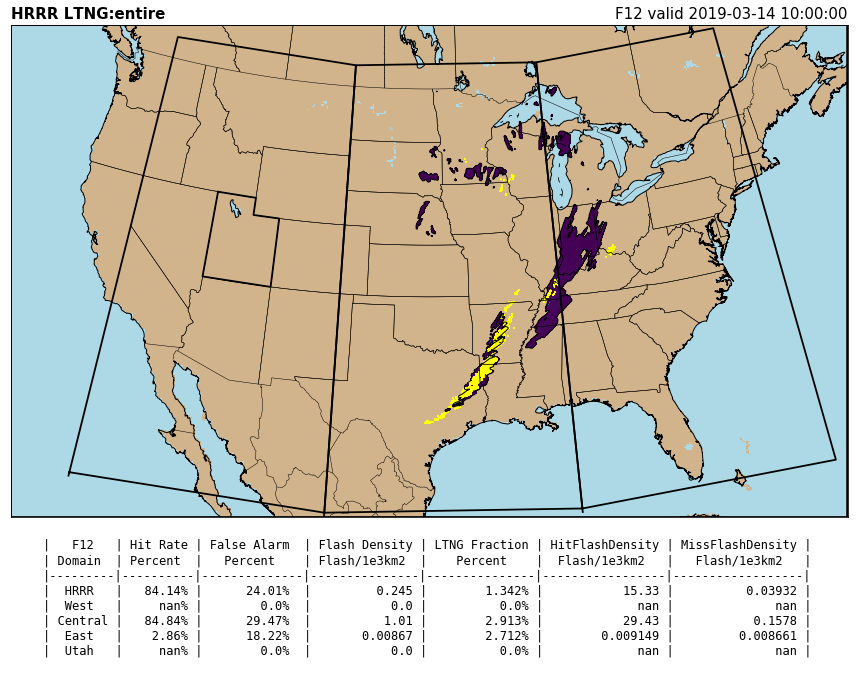

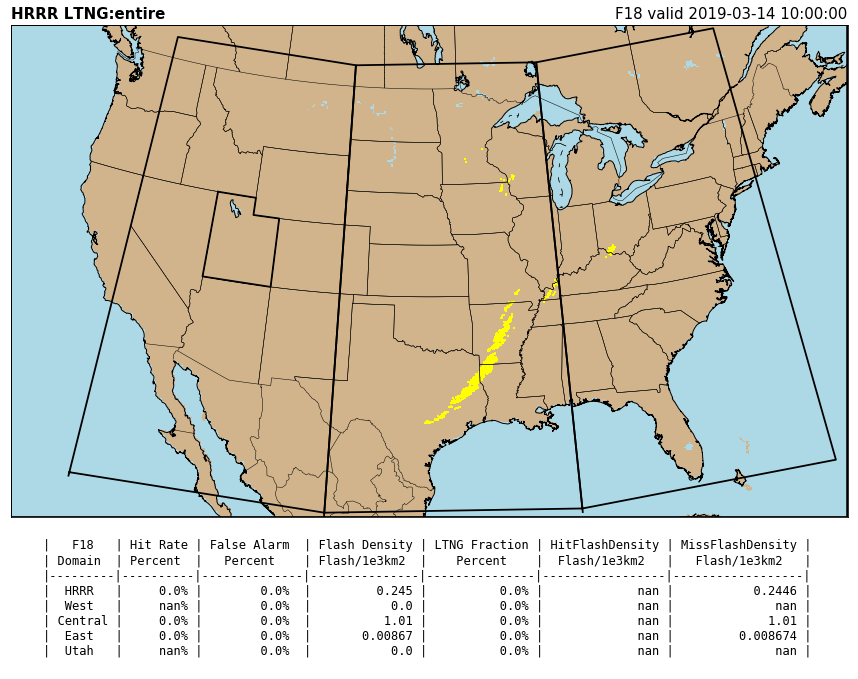

In [245]:
for fxx in [1, 6, 12, 18]:
    H = get_hrrr_variable(DATE-timedelta(hours=fxx), 'LTNG:entire', fxx=fxx, verbose=False)

    plt.figure(figsize=(15,10))

    m.pcolormesh(H['lon'], H['lat'], H['value'], latlon=True)
    m.scatter(G['longitude'], G['latitude'], latlon=True, c='yellow', marker='+', s=2)
    m.contour(H['lon'], H['lat'], H['value'].data, levels=[0], colors='k', latlon=True, linewidths=1)

    m.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
    m.drawcountries()
    m.drawstates()
    m.drawcoastlines()

    for i in PATH_points.keys():
        m.plot(PATH_points[i]['lon'], PATH_points[i]['lat'], latlon=True, color='k')


    plt.title('HRRR LTNG:entire', fontweight='semibold', loc='left')
    plt.title('F%02d valid %s' % (fxx, DATE), loc='right');


    text =  '| {:^7} | {:^8} | {:^12} | {:^13} | {:^13} | {:^15} | {:^16} |\n'.format('F%02d' % fxx, 'Hit Rate', 'False Alarm', 'Flash Density', 'LTNG Fraction', 'HitFlashDensity', 'MissFlashDensity')
    text += '| {:^7} | {:^8} | {:^12} | {:^13} | {:^13} | {:^15} | {:^16} |\n'.format('Domain', 'Percent', 'Percent', 'Flash/1e3km2', 'Percent', 'Flash/1e3km2', 'Flash/1e3km2')
    text += '|---------|----------|--------------|---------------|---------------|-----------------|------------------|\n'

    for D in PATH_verts.keys():
        DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/HRRR_GLM_hit_rate_data/'
        FILE = 'GLM_in_HRRR_%s_%s_m%02d_h%02d.csv' % (D, DATE.year, DATE.month, DATE.hour)
        data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
        # NOTE: Set encoding to 'UTF-8' so the date doesn't return as bytes

        # Get the data from the line that cooresponds to the date requested
        day_line = data[DATE.day-1]

        # Double check that the line we got is the date requested
        if datetime.strptime(day_line[0], '%Y-%m-%d %H:%M:%S') != DATE:
            print('WARNING: Date of this line does not match the requested DATE')

        hit = data['F%02d_Hit_Rate' % fxx][DATE.day-1]
        false = data['F%02d_False_Alarm' % fxx][DATE.day-1]
        LTNG_area = data['F%02d_Total_Area_km2' % fxx][DATE.day-1]
        flashes = data['GLM_FLASH_COUNT'][DATE.day-1]
        DOM_area = area_sqkm[D]

        flashesPerDomainArea = flashes/DOM_area*1000                    # flashes/1000km2
        LTNG_area_percentage = LTNG_area/DOM_area*100                   # Percent
        hitFlashDensity = (flashes*hit)/LTNG_area*1000                  # flashes/1000km2
        misFlashDensity = (flashes*(1-hit))/(DOM_area - LTNG_area)*1000 # flashes/1000km2

        text += '| {:^7} | {:>7.4}% | {:>10.4}%  | {:>13.3} | {:>12.4}% | {:>15.4} | {:>16.4} |\n'.format(D,
                                                                                                 hit*100,
                                                                                                 false*100,
                                                                                                 flashesPerDomainArea,
                                                                                                 LTNG_area_percentage,
                                                                                                 hitFlashDensity,
                                                                                                 misFlashDensity)
    plt.figtext(.155, -.05, text, fontname='monospace', fontsize=12);

    plt.savefig(SAVEDIR+'EVENT/%s_F%02d' % (DATE.strftime('%Y-%m-%d_%H%M'), fxx))
    
    print(text)

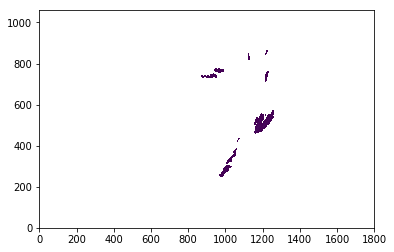

In [244]:
fxx = 16
H = get_hrrr_variable(DATE-timedelta(hours=fxx), 'LTNG:entire', fxx=fxx, verbose=False)
plt.pcolormesh(H['value'])